In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx
import requests

In [4]:
# Options
pd.set_option('max_colwidth', 500)


In [5]:
df = pd.read_csv('./data/transactions.csv', low_memory=False)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147175 entries, 0 to 1147174
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   block_time           1147175 non-null  object 
 1   block_number         1147175 non-null  float64
 2   hash                 1147175 non-null  object 
 3   tx_fee               1147175 non-null  float64
 4   nonce                1147175 non-null  float64
 5   from                 1147175 non-null  object 
 6   to                   1147174 non-null  object 
 7   method_id            1147175 non-null  object 
 8   project              902451 non-null   object 
 9   token_bought_symbol  901866 non-null   object 
 10  token_sold_symbol    901742 non-null   object 
 11  token_bought_amount  901866 non-null   float64
 12  token_sold_amount    901742 non-null   float64
 13  amount_usd           901559 non-null   float64
 14  tx_from              902451 non-null   object 
 15

In [6]:
# Helper Functions
def fetch_token_price(token_symbol):
  api = 'https://min-api.cryptocompare.com/data/price'
  res = requests.get('{}?fsym={}&tsyms=USD'.format(api, token_symbol)).json()
  if 'USD' in res:
    return res['USD']
  else:
    return 0

def fetch_text_signature(hex_signature):
  if len(hex_signature) != 10:
    return ''
  
  api = 'https://www.4byte.directory/api/v1/signatures'
  res = requests.get('{}/?hex_signature={}'.format(api, hex_signature)).json()
  
  if res['count'] == 0:
    return ''
  
  return res['results'][len(res['results']) - 1]['text_signature']

def format_currency(number):
  suffixes = ['', 'K', 'M', 'B']
  suffix_index = 0
  
  while number >= 1000 and suffix_index < len(suffixes) - 1:
    number /= 1000
    suffix_index += 1

  formatted_number = '{:.0f}{}'.format(number, suffixes[suffix_index])

  return '$' + formatted_number


In [68]:
# Constant variables
PRIMARY_COLOR = '#519259'
BUY_COLOR = '#5F8D4E'
SELL_COLOR = '#EB455F'
BLACK_COLOR = '#000000'
GRAY_COLOR = '#B2B2B2'

In [7]:
# Overview
start_time = df['block_time'].iloc[0]
end_time = df['block_time'].iloc[-1]
start_block = int(df['block_number'].iloc[0])
end_block = int(df['block_number'].iloc[-1])
total_transasctions = df['hash'].unique().size
total_wallet = df['from'].unique().size
total_eth_paid = round(df.drop_duplicates(['hash'])['tx_fee'].sum(), 2)
current_eth_price = fetch_token_price('ETH')
total_trading_volume = round(df['amount_usd'].sum())

print('Overview:')
print('Time: {} to {}'.format(start_time, end_time))
print('Block: {} to {} ~{} blocks'.format(start_block, end_block, end_block - start_block))
print('Total transasctions: {:,} transactions'.format(total_transasctions))
print('Total unique user: {:,} users'.format(total_wallet))
print('Total fee paid: {:,} ETH ~${:,}'.format(total_eth_paid, round(total_eth_paid * current_eth_price)))
print('Total trading volume: ${:,}'.format(total_trading_volume))


Overview:
Time: 2023-04-14 14:51:35.000 UTC to 2023-05-21 14:02:47.000 UTC
Block: 17046105 to 17308208 ~262103 blocks
Total transasctions: 822,804 transactions
Total unique user: 183,322 users
Total fee paid: 12,064.72 ETH ~$21,910,979
Total trading volume: $5,286,249,609


In [8]:
# Fresh bird: Wallet with the first swap transaction
minimum_nonce = 0
df_drop_duplicate_hahs = df.drop_duplicates(['hash'])
df_fresh_bird = df_drop_duplicate_hahs[
  (df_drop_duplicate_hahs['nonce'] <= minimum_nonce)
  & (df_drop_duplicate_hahs['project'].notnull())
  & (df_drop_duplicate_hahs['token_bought_symbol'] == 'PEPE')
]
number_of_fresh_bird = df_fresh_bird['from'].unique().size

print('{:,} fresh wallets '.format(number_of_fresh_bird))

# Early bird: Buy after liquidity was added on the first day
df_early_bird = df_fresh_bird[df_fresh_bird['block_time'] < '2023-04-15 15:00:00.000 UTC']
number_of_early_bird_wallet = df_early_bird['from'].unique().size
print('{:,} freshest wallets '.format(number_of_early_bird_wallet))
print('Example:')
print (df_early_bird['from'].head(10))


25,803 fresh wallets 
61 freshest wallets 
Example:
5     0xf5c0cdb9e18a4af157fdd369540ec9f4912b5edf
6     0x1298652974068e0d3a7bcdd6e29d6409101833ac
7     0x8ccf59bc5daafc43ff67f9825f08bbfbabc5cef6
8     0xe7a63eb84850f42b5e54a8a24a8cb4fdbf2be1f8
11    0x3191203c8a89d71a8f5a35140e2c7f2477396c92
13    0x08f120a352c16ab1d58bca16f845377e087e9e4c
16    0xb1b15945842b4b68565caa2f10dad59b6d66e5c6
17    0xb903e91bc67fa5c08ea151b17447a5b775eb7fe9
18    0x36c2b911fb9152f077ac26d4e67c7cbdf3b615a9
19    0x5979ce78d9d25e3c6ca5422dd3a8abf3133ba7b8
Name: from, dtype: object


In [9]:
def transfer_to_edges(arr):
  edges = []
  tg = arr[0] if len(arr[0]) < 42 else arr[0][:6]
  for i in range(len(arr) - 1):
    fr = arr[i + 1][:6]
    edges.append((fr, tg))

  return edges

g_group_1 = transfer_to_edges(
  [
    '0x5e74714501f7f2f8e7c3397c796189484e5304ee', # Related mobdad.eth
    '0xf5c0cdb9e18a4af157fdd369540ec9f4912b5edf',
    '0xe7a63eb84850f42b5e54a8a24a8cb4fdbf2be1f8',
    '0x8ccf59bc5daafc43ff67f9825f08bbfbabc5cef6',
    '0xe46b6fef0daa72dfab6ab5f430c635997d9f4bb9',
    '0x9bd5c8bfbe7e0fd78693f1f7e5b3610bdda9d5aa',
    '0x1298652974068e0d3a7bcdd6e29d6409101833ac',
    '0x3ad3940b5a56f86a181f7989045b2c7deb7f8356', # -> 0xf8684b3a3de555d977603558770c9d5127986e4a (Funded by mobdad.eth)
    '0xf8684b3a3de555d977603558770c9d5127986e4a',
    '0x1b5cec47f48d69d89eaa435149954115206303f7',
    '0x6da1fd46ba1044b5a40e0e4258e01ce19ab231ce',
    '0x7b7e034162139c507455e70adabdbd5c204e3a98',
    '0x2ce25fb6f4df177da6fe974638f728eabac5e3b6',
    '0xf03771f583c78f476e3f8c957e79c134f4fdc351'
  ]
)

g_group_2 = transfer_to_edges(
  [
    'Houbi',
    '0x5dd3e5931da643daa2f5ac322503757225566c29',
    '0x2a81048da186e75865605a2e10ae663f8d63003d',
    '0xb71bce9ec5d0a66215a032d6daa83e743eeef380',
    '0xb1f06a0f6154df25dba5033ea04782031495cdc8',
    '0x15ddbc80da895519a90625bd6210671298f76769',
    '0x3ca3a6d10a8489d17c31f591930940c3da70f9fd',
    '0x946990daabd864c3d96ec0ffc59335f4e25696ae',
    '0x4e9d602c1bc0dfd59ea37a67824f505dd1f659b8',
    '0x674891702311283baabd9238d3757588979cbaab',
    '0xcbcb59bb755ce859568733679ce3e5f23c3445a9',
    '0x2b230e525a116e85df9af3b1357834d33bc3dff8',
    '0x48c831676ca4188c0c10563733baa97c088a5b53',
    '0xad106e36fb4e94387f85342d9d9c31aaf5ce293b',
    '0xde85bb9a4f3b414518649f2804e01860063bf11d',
    '0xb0e0864e63cda1ae4b09bb9e0365fb3d1921197d'
  ]
)

g_group_3 = transfer_to_edges(
  [
    'Bybit', # Related badussy.eth, peppertokenerc.eth
    '0x08f120a352c16ab1d58bca16f845377e087e9e4c',
    '0xb1b15945842b4b68565caa2f10dad59b6d66e5c6', # -> 0xd571e1ea0bdb88569af3df6a72e94606006bbc79 (Funded by badussy.eth)
    '0xb903e91bc67fa5c08ea151b17447a5b775eb7fe9',
    '0xb790ee1a15964569573f3105c26033c3353a5f17',
    '0x26e2c9c8629fcb13d0b30db6447e577816ddd805',
    '0x19848274b125f4f75c6d0524f5196473c023d21a',
    '0xdfd45debf66d2f352cd1cdab260c9ef70ab8fe9d'
  ]
)


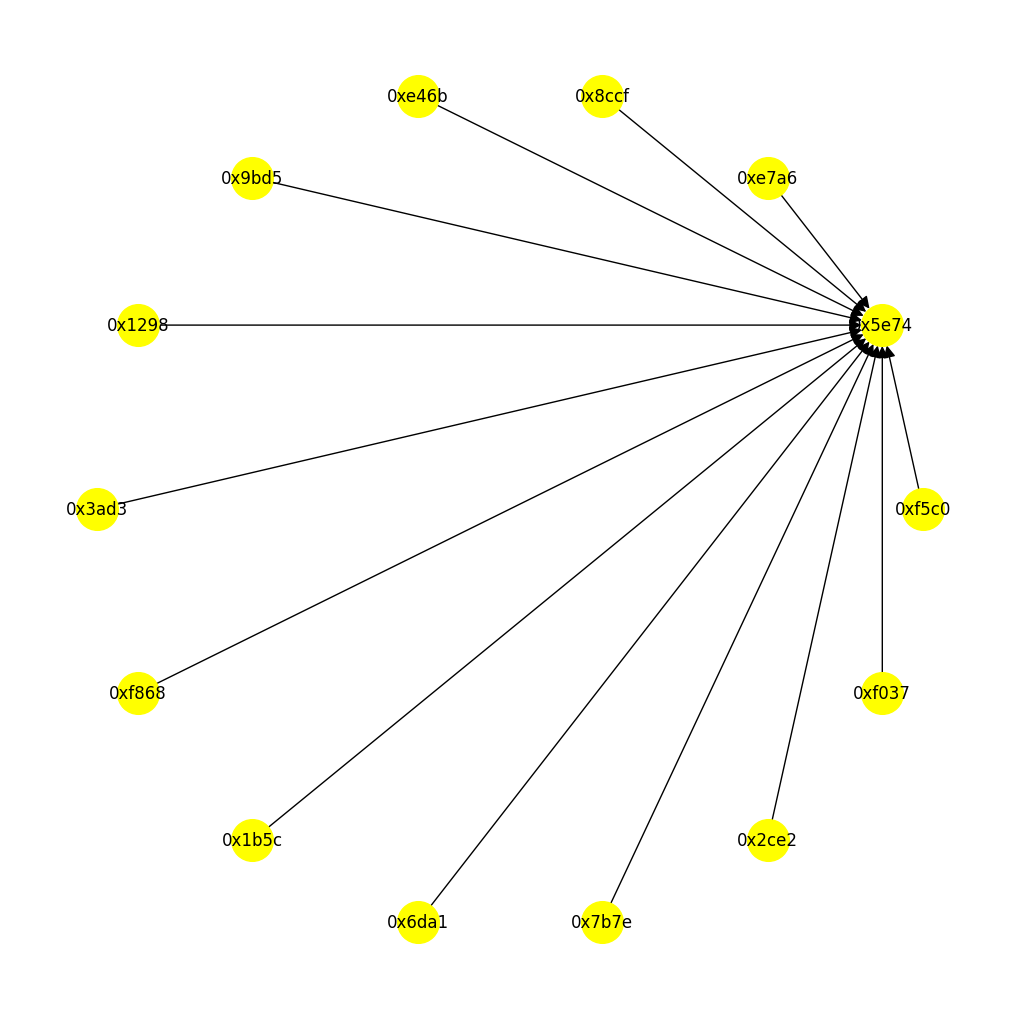

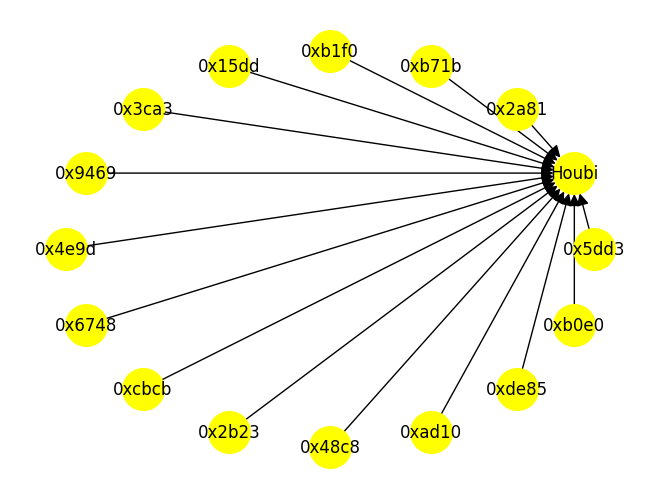

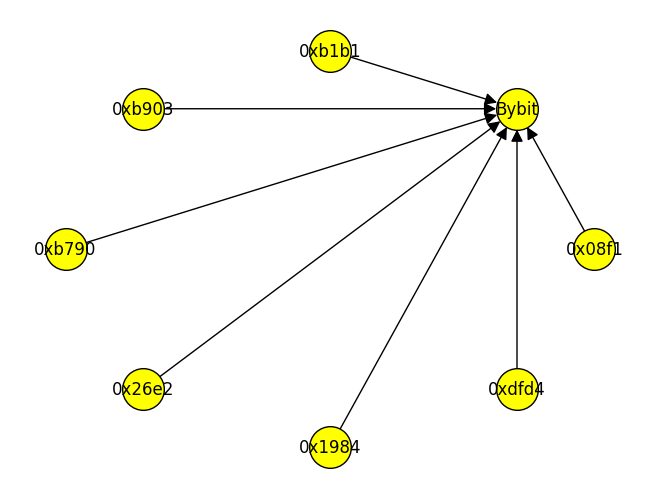

In [10]:
plt.figure(figsize=(10, 10))
G1 = nx.DiGraph(directed=True)
G2 = nx.DiGraph(directed=True)
G3 = nx.DiGraph(directed=True)

G1.add_edges_from(g_group_1)
G2.add_edges_from(g_group_2)
G3.add_edges_from(g_group_3)

options = {
  'node_color': 'yellow',
  'node_size': 900,
  'width': 1,
  'arrowstyle': '-|>',
  'arrowsize': 18
}

plt.figure(1)
nx.draw(G1, nx.circular_layout(G1), with_labels=True, arrows=True, **options)

plt.figure(2)
nx.draw(G2, nx.circular_layout(G2), with_labels=True, arrows=True, **options)

plt.figure(3)
nx.draw(G3, nx.circular_layout(G3), with_labels=True, arrows=True, **options)

ax = plt.gca()
ax.collections[0].set_edgecolor('#000000')

plt.show()

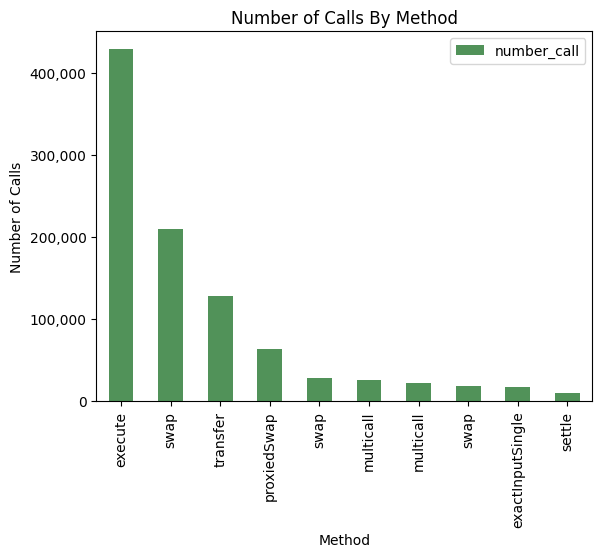

In [69]:
# Count method id
def get_text_signature(method_id):
  text = fetch_text_signature(method_id)
  text = text.split('(')[0]
  return text

df_methods = df.groupby(['method_id'])['method_id'] \
  .count() \
  .reset_index(name='number_call') \
  .sort_values(['number_call'], ascending=False) \
  .head(10)

df_methods['method_text'] = df_methods.apply(lambda x: get_text_signature(x['method_id']), axis=1)

ax = df_methods.plot.bar(
  title='Number of Calls By Method',
  x='method_text',
  y='number_call',
  xlabel='Method',
  ylabel='Number of Calls',
  color=PRIMARY_COLOR
)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: format(int(y), ',')))

plt.show()


In [12]:
# Format block time
columns = [
  'block_time',
  'hash',
  'project',
  'token_bought_symbol',
  'token_sold_symbol',
  'token_bought_amount',
  'token_sold_amount',
  'amount_usd'
]
df_with_floor_time_by_hour = df.loc[:, columns]
df_with_floor_time_by_hour['block_time'] = pd \
  .to_datetime(df_with_floor_time_by_hour['block_time']) \
  .dt.floor('H') \
  .dt.strftime('%Y-%m-%d %H:%M:%S')

df_with_floor_time_by_day = df_with_floor_time_by_hour.loc[:]
df_with_floor_time_by_day['block_time'] = pd \
  .to_datetime(df_with_floor_time_by_day['block_time']) \
  .dt.floor('D') \
  .dt.strftime('%Y-%m-%d')


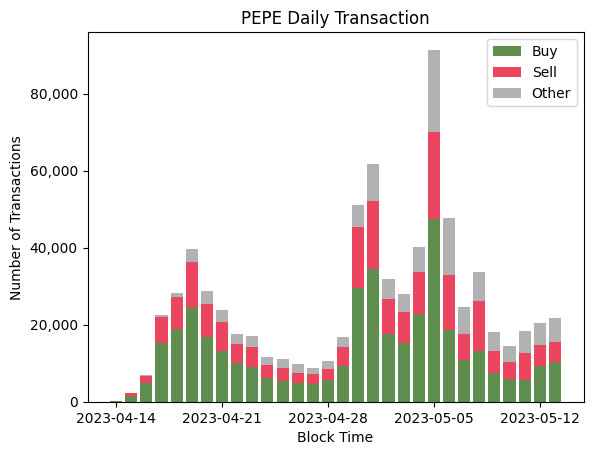

In [70]:
# Daily transaction
def get_other_count(row):
  return row['total_tx_count'] - row['tx_buy_count'] - row['tx_sell_count']

df_tx = df_with_floor_time_by_day.drop_duplicates(['hash'])
df_tx_count = df_tx \
  .groupby('block_time')['hash'] \
  .count() \
  .reset_index(name='total_tx_count')

df_swap_only = df_tx[df_tx['project'].notna()]
df_buy_count = df_swap_only \
  .groupby('block_time')['token_bought_symbol'] \
  .apply(lambda x: (x == 'PEPE').sum()) \
  .reset_index(name='tx_buy_count')

df_sell_count = df_swap_only \
  .groupby('block_time')['token_sold_symbol'] \
  .apply(lambda x: (x == 'PEPE').sum()) \
  .reset_index(name='tx_sell_count')

df_counter = df_tx_count.merge(
  df_buy_count.merge(df_sell_count, how='inner', on='block_time'),
  how='inner',
  on='block_time'
)

df_counter = df_counter.assign(tx_other_count = lambda x: get_other_count(x))

# Draw bar chart
_, ax = plt.subplots()
ax.bar(df_counter['block_time'], df_counter['tx_buy_count'], color=BUY_COLOR)
ax.bar(df_counter['block_time'], df_counter['tx_sell_count'], bottom=df_counter['tx_buy_count'], color=SELL_COLOR)
ax.bar(df_counter['block_time'], df_counter['tx_other_count'], bottom=df_counter['tx_buy_count'] + df_counter['tx_sell_count'], color=GRAY_COLOR)

ax.set_xlabel('Block Time')
ax.set_ylabel('Number of Transactions')
ax.set_title('PEPE Daily Transaction')
ax.legend(['Buy', 'Sell', 'Other'])

# Show ticks at every 7 days
ax.set_xticks(range(0, len(df_counter['block_time']), 7))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: format(int(y), ',')))

plt.show()


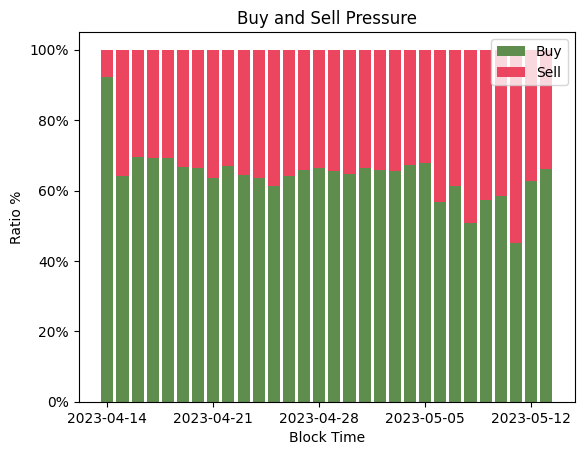

In [71]:
# Ratio of buy and sell
def get_buy_percentage(row):
  return round((row['tx_buy_count'] / (row['tx_buy_count'] + row['tx_sell_count'])) * 100, 2)

df_swap_ratio = df_counter[['block_time', 'tx_buy_count', 'tx_sell_count']]
df_swap_ratio = df_swap_ratio.assign(buy_percentage = lambda x: get_buy_percentage(x))
df_swap_ratio = df_swap_ratio.assign(sell_percentage = lambda x: 100 - x['buy_percentage'])

_, ax = plt.subplots()
ax.bar(df_swap_ratio['block_time'], df_swap_ratio['buy_percentage'], color=BUY_COLOR)
ax.bar(df_swap_ratio['block_time'], df_swap_ratio['sell_percentage'], bottom=df_swap_ratio['buy_percentage'], color=SELL_COLOR)

ax.set_title('Buy and Sell Pressure')
ax.set_xlabel('Block Time')
ax.set_ylabel('Ratio %')
ax.legend(['Buy', 'Sell'])

# Show ticks at every 7 days
ax.set_xticks(range(0, len(df_counter['block_time']), 7))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()


Number of transactions: 822,804 transactions
Number of swap transactions: 620,393 transactions
Swap ratio: 75.4%


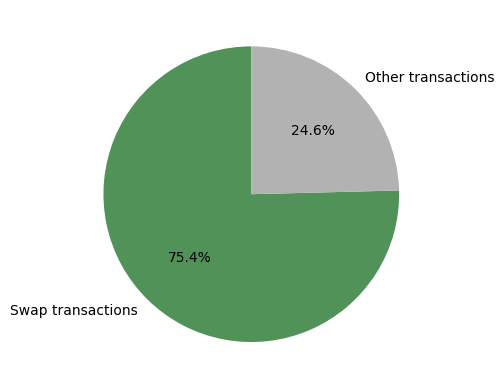

In [72]:
# Swap rate
df_unique_hash = df.drop_duplicates(['hash'])
number_of_txs = len(df_unique_hash)
number_of_swap_txs = len(df_unique_hash[df_unique_hash['project'].notna()])

swap_rate = round((number_of_swap_txs / number_of_txs) * 100, 2)

print('Number of transactions: {:,} transactions'.format(number_of_txs))
print('Number of swap transactions: {:,} transactions'.format(number_of_swap_txs))
print('Swap ratio: {}%'.format(swap_rate))

plt.pie(
  [swap_rate, 100 - swap_rate],
  labels=['Swap transactions', 'Other transactions'],
  colors=[PRIMARY_COLOR, GRAY_COLOR],
  startangle = 90,
  autopct='%1.1f%%'
)
plt.show()

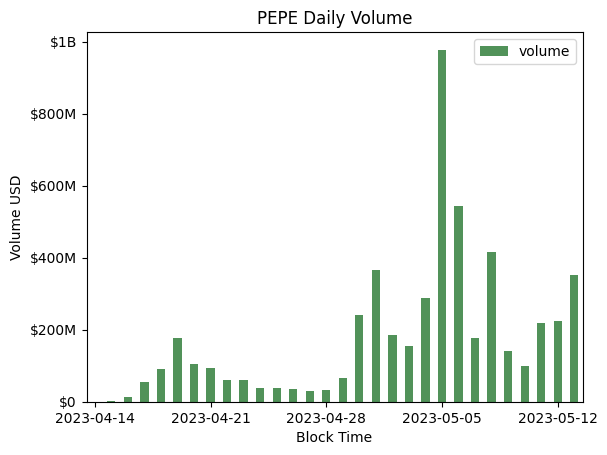

In [81]:
# Daily and cummulative volume
df_swaps = df_with_floor_time_by_day[df_with_floor_time_by_day['project'].notna()]
df_volume = df_swaps \
  .groupby('block_time')['amount_usd'] \
  .sum() \
  .reset_index(name='volume')

df_volume['cummulative_volume'] = df_volume['volume'] \
  .cumsum()

ax = df_volume.plot.bar(
  title='PEPE Daily Volume',
  x='block_time',
  y='volume',
  xlabel='Block Time',
  ylabel='Volume USD',
  rot=0,
  color=PRIMARY_COLOR
)

# Show ticks and lables at every 7 days
ax.set_xticks(range(0, len(df_counter['block_time']), 7))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: format_currency(y)))

plt.show()


         project  total_volume
5      uniswap-3  2.993002e+09
4      uniswap-2  2.268335e+09
3  pancakeswap-3  2.059818e+07
0         DODO-0  3.572229e+06
2     maverick-1  7.244982e+05
1     balancer-2  1.848226e+04


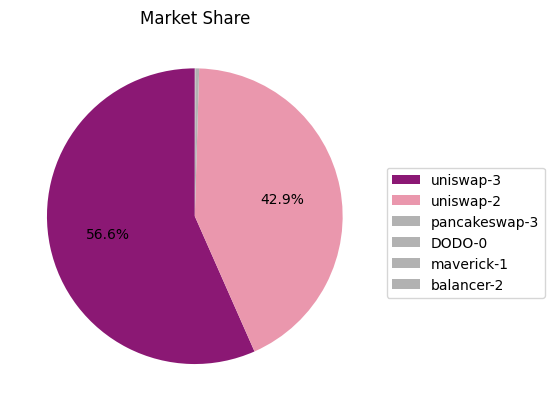

In [87]:
# Market share
df_market_share = df_swaps \
  .groupby('project')['amount_usd'] \
  .sum() \
  .reset_index(name='total_volume') \
  .sort_values(by=['total_volume'], ascending=False)

print(df_market_share)

def autopct_cleaner(pct):
  return ('%1.1f%%' % pct) if pct > 10 else ''

plt.pie(
  df_market_share['total_volume'],
  startangle = 90,
  autopct=autopct_cleaner,
  colors=['#8B1874', '#EA97AD', GRAY_COLOR, GRAY_COLOR, GRAY_COLOR, GRAY_COLOR]
)
plt.legend(labels=df_market_share['project'], bbox_to_anchor=(1, 0.65))
plt.title('Market Share')
plt.show()

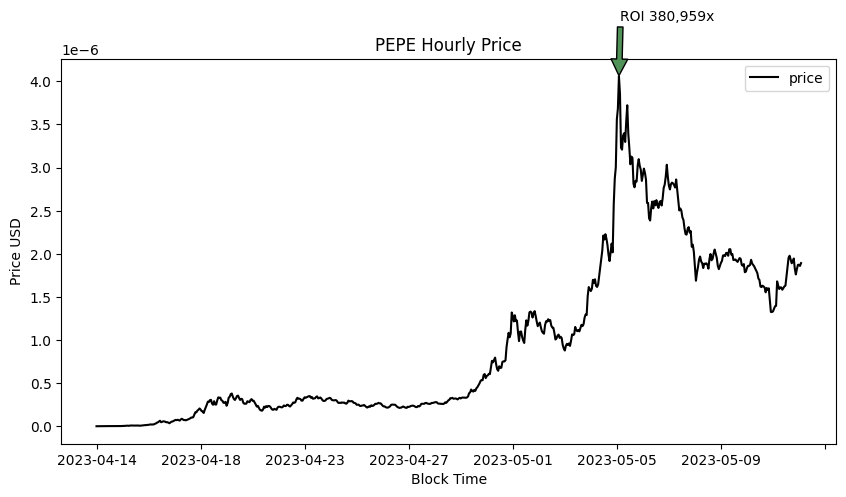

In [80]:
# Hourly price
df_price = df_with_floor_time_by_hour[df_with_floor_time_by_hour['project'].notna()] \
  .assign(price = lambda x:
    x['amount_usd'] / df.apply(
    lambda x: x['token_bought_amount']
      if x['token_bought_symbol'] == 'PEPE'
      else x['token_sold_amount']
    , axis=1
))

df_price = df_price.groupby('block_time')['price'].mean().reset_index()
df_price['block_time'] = pd.to_datetime(df_price['block_time']).dt.strftime('%Y-%m-%d')

# Remove anomaly data
df_price.drop(df_price[df_price['block_time'] == '2023-05-12'].index, inplace=True)

init_price = df_price['price'].iloc[0]
highest_price = df_price['price'].max()
highest_price_index = df_price['price'].idxmax()
roi = round(highest_price / init_price)

# Draw figure
ax = df_price.plot.line(
  title='PEPE Hourly Price',
  x='block_time',
  y='price',
  xlabel='Block Time',
  ylabel='Price USD',
  figsize=(10, 5),
  color=BLACK_COLOR
)
ax.annotate(
  'ROI {:,}x'.format(roi),
  xy=(highest_price_index, highest_price),
  xycoords='data',
  xytext=(1, 40),
  textcoords='offset points',
  arrowprops=dict(facecolor=PRIMARY_COLOR, shrink=0.01),
)

plt.show()


In [93]:
# Address by volume
def get_number_of_address_by_volume(min, max):
  return len(df_address_volume[
    (df_address_volume['total_volume'] > min)
    & (df_address_volume['total_volume'] <= max)
  ])

df_address_volume = df[df['project'].notna()]

df_address_volume = df_address_volume \
  .groupby('tx_from')['amount_usd'] \
  .sum() \
  .reset_index(name='total_volume') \
  .sort_values(by=['total_volume'], ascending=False) 

for i in range(7):
  min = pow(10, 0 if i == 0 else i + 2)
  max = pow(10, i + 3)
  num_address = get_number_of_address_by_volume(min, max)
  ratio = round((num_address / len(df_address_volume)) * 100, 2)
  print('Number of address with volume (${:,}-${:,}]: {:,} addresses ({}%)'
    .format(min, max, num_address, ratio)
  )

print('\n')
print('Top 10 address with highest trading volume:')
df_address_volume \
    .rename(columns={'tx_from': 'Address', 'total_volume': 'Volume ($)'}) \
    .reset_index(drop=True) \
    .head(10) \
    .style.format({'Volume ($)': '${:,.0f}'})

Number of address with volume ($1-$1,000]: 84,881 addresses (58.02%)
Number of address with volume ($1,000-$10,000]: 42,766 addresses (29.23%)
Number of address with volume ($10,000-$100,000]: 14,115 addresses (9.65%)
Number of address with volume ($100,000-$1,000,000]: 3,392 addresses (2.32%)
Number of address with volume ($1,000,000-$10,000,000]: 688 addresses (0.47%)
Number of address with volume ($10,000,000-$100,000,000]: 47 addresses (0.03%)
Number of address with volume ($100,000,000-$1,000,000,000]: 2 addresses (0.0%)


Top 10 address with highest trading volume:


,Address,Volume ($)
0,0xae2fc483527b8ef99eb5d9b44875f005ba1fae13,"$596,395,801"
1,0xd985c35f566c9de55df16ade36852b0c40f4bf59,"$159,873,310"
2,0xf1d307906edc902dc2c392af2880f43a55d3583a,"$94,425,641"
3,0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb,"$66,011,846"
4,0x758e8229dd38cf11fa9e7c0d5f790b4ca16b3b16,"$61,443,605"
5,0xb58555fcba6479fced7de1485eb054943a09af7b,"$55,737,365"
6,0x381b7d64303a2a5251ac12ee147ffdb337da5969,"$51,931,828"
7,0xd9d9cb8037d8a11a511398c3a790ded9bdf21b08,"$42,040,175"
8,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,"$41,181,994"
9,0xa009fa1ac416ec02f6f902a3a4a584b092ae6123,"$40,206,754"


In [20]:
pd.set_option('mode.chained_assignment', None)

# RealizedPnl of Address (Not include transactions on centralized exchanges or transfers to other wallets)
df_address_profit = df[df['project'].notna()]

df_address_profit['realized_pnl'] = df_address_profit.apply(
  lambda x: -x['amount_usd']
    if x['token_bought_symbol'] == 'PEPE'
    else x['amount_usd']
  , axis=1
)

print('Top 10 address by RealizedPnL')
pd.pivot_table(
  df_address_profit,
  index=['tx_from'],
  aggfunc={'realized_pnl': np.sum, 'hash': len}
).rename(columns={'tx_from': 'Address', 'realized_pnl': 'RealizedPnL ($)', 'hash': 'Number of swaps'}) \
  .sort_values(['RealizedPnL ($)'], ascending=False) \
  .head(10) \
  .style.format({'RealizedPnL ($)': '${:,.0f}'})


Top 10 address by RealizedPnL


,Number of swaps,RealizedPnL ($)
tx_from,,
0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb,1882,"$66,011,846"
0xfd9ce48c96617bf6ccc7c37044b1a22638b71e02,477,"$11,263,332"
0xc32ad590d92db58931dcedd99e10d077530ccaa9,49,"$10,035,381"
0x511d452b738b3f1ada0e74e7a3412f5d975fc548,705,"$9,564,909"
0x4a2c786651229175407d3a2d405d1998bcf40614,508,"$9,096,246"
0x2cc9aecaec5a7577d27b80afb70b8fda55ee68c0,211,"$7,549,952"
0x03770b07c5c315722c5866e64cde04e6e5793714,127,"$7,144,450"
0x45cf108e79374ad324904c22847569609f48e33c,319,"$7,138,063"
0x31a9ec3a6e29039c74723e387de42b79e6856fd8,514,"$6,598,426"


                                              from  total_fee_paid
125685  0xae2fc483527b8ef99eb5d9b44875f005ba1fae13     1692.215213
131944  0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb      159.396316
84964   0x758e8229dd38cf11fa9e7c0d5f790b4ca16b3b16      127.428163
85990   0x76f36d497b51e48a288f03b4c1d7461e92247d5e      120.186694
173255  0xf1d307906edc902dc2c392af2880f43a55d3583a      106.554715
130767  0xb58555fcba6479fced7de1485eb054943a09af7b       63.127753
96655   0x85b4ad5f4f563e549a33d5b0b23c1091aa03d2ac       59.809949
115403  0xa009fa1ac416ec02f6f902a3a4a584b092ae6123       49.879204
128001  0xb18ccf69940177f3ec62920ddb2a08ef7cb16e8f       48.932089
39933   0x381b7d64303a2a5251ac12ee147ffdb337da5969       46.196109


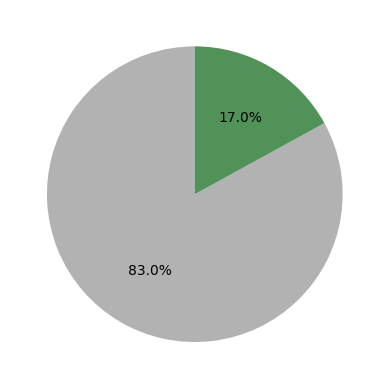

In [75]:
# Top address paid fee
df_top_fee_paid = df.drop_duplicates(['hash']) \
  .groupby('from')['tx_fee'] \
  .sum() \
  .reset_index(name='total_fee_paid') \
  .sort_values(by=['total_fee_paid'], ascending=False) \
  .head(10)

print(df_top_fee_paid)

plt.pie(
  [total_eth_paid, df_top_fee_paid['total_fee_paid'].sum()],
  colors=[GRAY_COLOR, PRIMARY_COLOR],
  startangle = 90,
  autopct='%1.1f%%'
)
plt.show()

In [22]:
# Show all swap transactions of address
address = '0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb'

df[
  (df['project'].notna()) &
  (df['tx_from'] == address)
][['block_time', 'hash', 'token_bought_symbol', 'token_sold_symbol', 'amount_usd']]


,block_time,hash,token_bought_symbol,token_sold_symbol,amount_usd
308848,2023-04-28 01:01:47.000 UTC,0x035f83fecfdea62b314d91a290a20356ce0f85e2e14e712f5b5ccbfc30573953,WETH,PEPE,12206.663163
308852,2023-04-28 01:01:47.000 UTC,0x035f83fecfdea62b314d91a290a20356ce0f85e2e14e712f5b5ccbfc30573953,WETH,PEPE,12206.663163
309731,2023-04-28 02:41:11.000 UTC,0x4644fd14ef8d50c02f12ebe0da3f44b3578311bc14b7fb4aa02870464b147b40,WETH,PEPE,493.113469
309737,2023-04-28 02:41:11.000 UTC,0x4644fd14ef8d50c02f12ebe0da3f44b3578311bc14b7fb4aa02870464b147b40,WETH,PEPE,493.113469
311847,2023-04-28 06:54:11.000 UTC,0xcfa989f1e957278aaec0b0e46f3adabc8e588af08012e79a0572c437b6fc240d,WETH,PEPE,9810.295761
...,...,...,...,...,...
1051002,2023-05-13 17:52:23.000 UTC,0xfe0d116f738c91dbbe27d6a54337394ae8db90894ebedb936f8939037afad296,WETH,PEPE,26751.094381
1062090,2023-05-13 23:30:35.000 UTC,0xea75646a68f0cf68ade137142d9dcb4b081fc0411b0a7ad898c43e52b837012c,WETH,PEPE,71219.287182
1062092,2023-05-13 23:30:35.000 UTC,0xea75646a68f0cf68ade137142d9dcb4b081fc0411b0a7ad898c43e52b837012c,WETH,PEPE,71219.287182
1062106,2023-05-13 23:30:35.000 UTC,0xea75646a68f0cf68ade137142d9dcb4b081fc0411b0a7ad898c43e52b837012c,WETH,PEPE,71219.287182
